In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from dataset import MetaDataset
from metadata.vcc import SanityMetadata

from models import save_model, load_model
from models.vae import ToyVAE
from maml import reptile_train

In [3]:
dataset = MetaDataset(SanityMetadata())
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-16 14:19:49.843487


In [29]:
device = torch.device('cpu')
model = ToyVAE()


def criterion(recon_y, y):
    BCE = F.binary_cross_entropy(recon_y, y, reduction='sum')
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784),
    #                              reduce=True, size_average=False)
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD
    return BCE


criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)


def train(trained_model, x, y, n_inner_loop=8):
    trained_model.train()
    x = torch.transpose(x, 0, 1)
    y = torch.transpose(y, 0, 1)
    x = x.to(device)
    y = y.to(device)
    for _ in range(n_inner_loop):
        optimizer.zero_grad()
        out = trained_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
    print(loss.item(), end='')

In [30]:
# Meta train

reptile_train(model, dataset, n_shot=None, n_iter_outer=100,
              outer_step_size=1e-1, inner_train_func=train)
save_model('saved_models/temp.pt', model)

Iter 0: 125.15090942382812
Iter 1: 101.79509735107422
Iter 2: 160.32931518554688
Iter 3: 131.1269989013672
Iter 4: 158.9755401611328
Iter 5: 116.06575775146484
Iter 6: 121.98399353027344
Iter 7: 188.1910858154297
Iter 8: 191.67498779296875
Iter 9: 133.74317932128906
Iter 10: 180.7340087890625
Iter 11: 90.64708709716797
Iter 12: 100.67535400390625
Iter 13: 98.85577392578125
Iter 14: 119.21156311035156
Iter 15: 151.88595581054688
Iter 16: 161.41265869140625
Iter 17: 118.2329330444336
Iter 18: 75.72713470458984
Iter 19: 117.98649597167969
Iter 20: 92.28262329101562
Iter 21: 210.2461395263672
Iter 22: 87.72587585449219
Iter 23: 111.031982421875
Iter 24: 125.01417541503906
Iter 25: 134.67056274414062
Iter 26: 106.5593490600586
Iter 27: 65.36372375488281
Iter 28: 106.77198791503906
Iter 29: 132.02468872070312
Iter 30: 69.64936828613281
Iter 31: 193.44789123535156
Iter 32: 79.97216033935547
Iter 33: 133.81033325195312
Iter 34: 120.16241455078125
Iter 35: 142.34764099121094
Iter 36: 86.4279861

In [33]:
# Second train after meta training

pretrained_model = load_model('saved_models/temp.pt', ToyVAE)


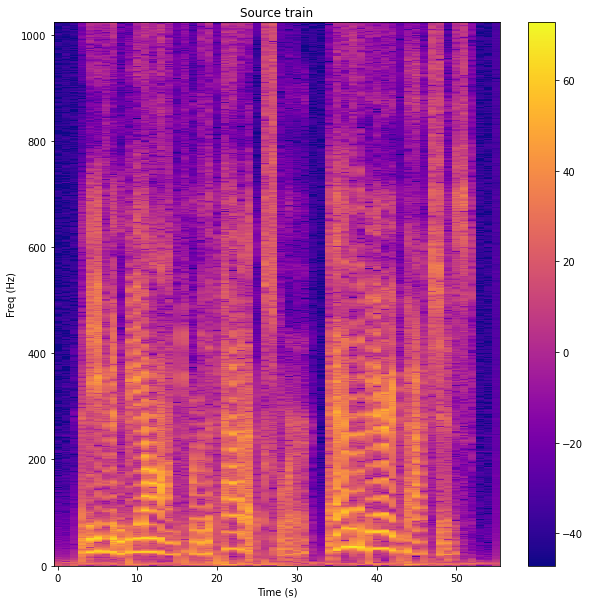

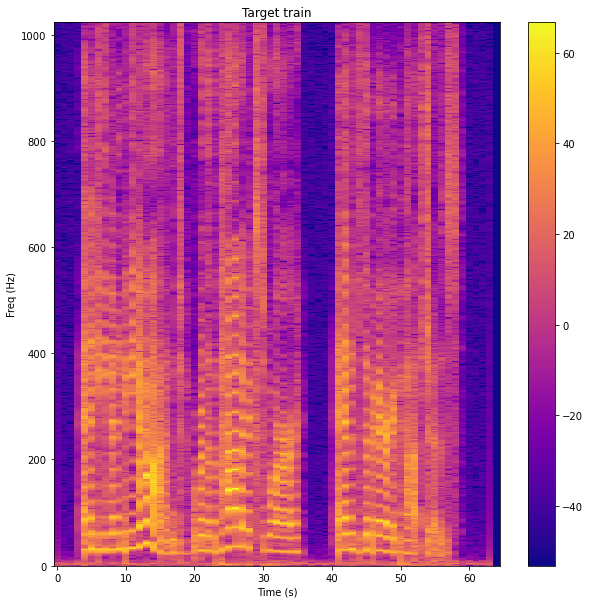

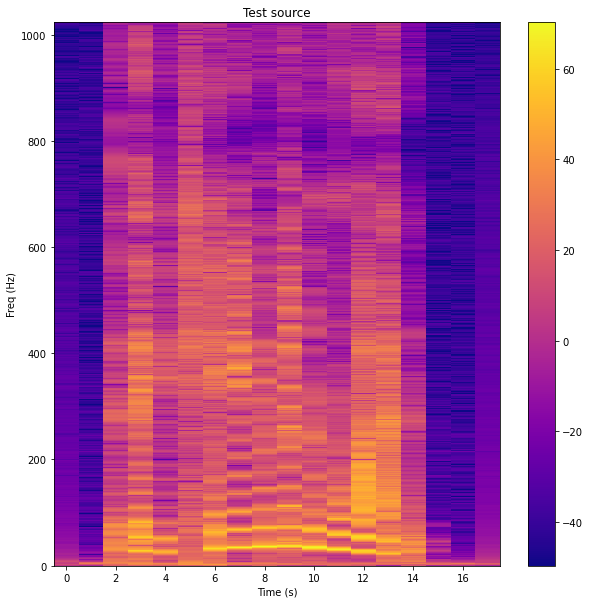

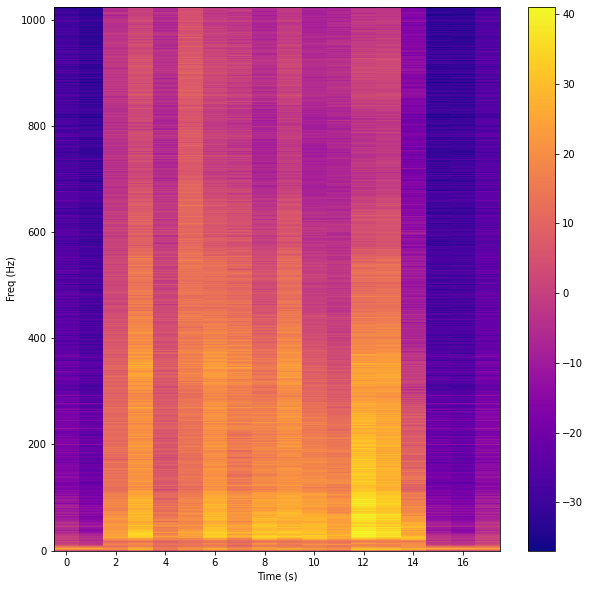

In [36]:
from transform import log_stft
from dataset import TaskDataset, InputData
from visualization import plot_spec


def test(model, train_source_filename, train_target_filename,
         test_input_filename):
    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train')
    plot_spec(log_stft(input_dat.dat.amp), title='Test source')
    x = input_dat.get()
    x = torch.from_numpy(x.T)
    estimated = model(x)
    plot_spec(estimated.detach().numpy().T)

meta_dat = SanityMetadata()

test(pretrained_model, meta_dat.get(0,0), meta_dat.get(1,0),
     meta_dat.get(0, 1))

In [ ]:
# test with actual samples
